# Filtrando ruído com autoencoder convolucional

Nesta aplicação o autocodificador é utilizado como filtro de ruído. 
Utiliza-se o dataset do MNIST, adicionando ruído gaussiano.
A rede é treinada com a entrada com a imagem ruidosa e a saída como a imagem original.

Esta é uma rede totalmente convolucional e para tanto, a rede aceita imagens de entrada de quaisquer dimensões.

## Importando as bibliotecas

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

# from os
#import os
import os.path

# from torch
import torch
from torch import nn
from torch.autograd import Variable
import torch.utils.data as data

# from torchvision
import torchvision
from torchvision.datasets import MNIST

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: False


## Carregando os dados

In [3]:
dataset_dir = './data/datasets/MNIST/'
processed_folder = 'processed'
training_file = 'training.pt'
test_file = 'test.pt'

# Download dos dados caso não existam
if not (os.path.exists(os.path.join(dataset_dir, processed_folder, training_file)) and
    os.path.exists(os.path.join(dataset_dir, processed_folder, test_file))):
    dataset_train = MNIST(dataset_dir, train=True, download=True)
    del dataset_train

# Carrega dados processados do disco
train_labels, _ = torch.load(os.path.join(dataset_dir, processed_folder, training_file))
test_labels, _ = torch.load(os.path.join(dataset_dir, processed_folder, test_file))

## Normalizando os dados e criando imagens com ruídos

In [4]:
# Normaliza os dados
train_labels = train_labels.type(torch.FloatTensor)/255
test_labels = test_labels.type(torch.FloatTensor)/255

# Cria imagens com ruído
noise_factor = 0.5
train_noisy = train_labels + torch.from_numpy(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_labels.shape)).type(torch.FloatTensor)
test_noisy = test_labels + torch.from_numpy(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_labels.shape)).type(torch.FloatTensor)

train_noisy = torch.clamp(train_noisy, 0., 1.)
test_noisy  = torch.clamp(test_noisy, 0., 1.)

print('amostras para treinamento:', len(train_noisy))
print('amostras para validação:',   len(test_noisy))

amostras para treinamento: 60000
amostras para validação: 10000


## Mostrando algumas imagens do conjunto de treinamento

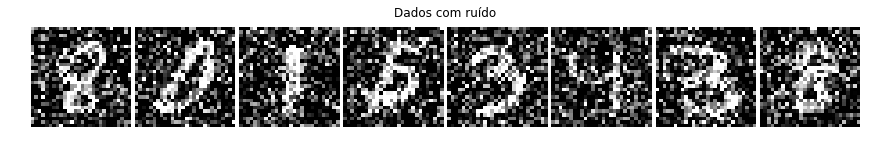

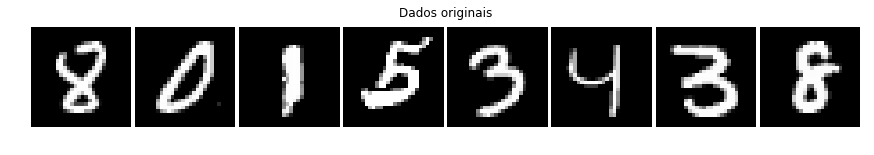

In [5]:
n_samples = 8

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_train = torch.utils.data.TensorDataset(train_noisy, train_labels)
temp_dataloader = torch.utils.data.DataLoader(temp_train, 
                                              batch_size = n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid_data = torchvision.utils.make_grid(image_batch.unsqueeze(1), normalize=True, pad_value=1.0, padding=1)
grid_labels = torchvision.utils.make_grid(labels.unsqueeze(1), normalize=True, pad_value=1.0, padding=1)

# dados com ruído
plt.figure(figsize=(15, 10))
plt.title("Dados com ruído")
plt.imshow(grid_data.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()
# dados originais
plt.figure(figsize=(15, 10))
plt.title("Dados originais")
plt.imshow(grid_labels.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

del temp_dataloader

## Cria DataLoader para os dados

In [ ]:
train = torch.utils.data.TensorDataset(train_noisy, train_labels)

train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1)

test = torch.utils.data.TensorDataset(test_noisy, test_labels)

test_loader = torch.utils.data.DataLoader(test,
                                         batch_size=10000,
                                         shuffle=False,
                                         num_workers=2)

## Definição das classes que representam as redes

In [ ]:
import torch.nn.functional as F

# classe do AutoEncoder (Encoder + Decoder)
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# classe do Encoder
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encode_conv1 = torch.nn.Conv2d(1, 16, 3, stride=3, padding=1)
        self.encode_pool1 = torch.nn.MaxPool2d(2, stride=2)
        self.encode_conv2 = torch.nn.Conv2d(16, 8, 3, stride=2, padding=1)
        self.encode_pool2 = torch.nn.MaxPool2d(2, stride=1)

    def forward(self, x):
        x = F.relu(self.encode_conv1(x))
        x = self.encode_pool1(x)
        x = F.relu(self.encode_conv2(x))
        x = self.encode_pool2(x)
        return x

# classe do Decoder
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decode_conv1 = torch.nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.decode_conv2 = torch.nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1)
        self.decode_conv3 = torch.nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1)
        
    def forward(self, x):
        x = F.relu(self.decode_conv1(x))
        x = F.relu(self.decode_conv2(x))
        x = F.tanh(self.decode_conv3(x))
        return x

## Rede autoencoder

In [ ]:
autoencoder = AutoEncoder(Encoder(), Decoder())
if use_gpu:
    autoencoder = autoencoder.cuda()

In [ ]:
input_img = Input(shape=(None, None, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = Model(input_img,decoded)

## Sumário da rede

Observe que nesta rede, as dimensões das imagens em todas as camadas podem ser quaisquer, com exceção dos canais (última dimensão) que são 1 na entrada (imagem de cinza) e 1 na saída (imagem de cinza).
Assim, esta rede é dita totalmente convolucional, aceitando portanto imagens de cinza de qualquer tamanho.

In [ ]:
print(autoencoder)

## Poucas amostras para teste inicial

In [ ]:
testing = True
if testing:
    n_samples = 1000
    x_train = x_train[:n_samples]
    x_train_noisy = x_train_noisy[:n_samples]
    
    n_samples_test = 200
    x_test = x_test[:n_samples_test]
    x_test_noisy = x_test_noisy[:n_samples_test]
print(x_train.shape, x_train_noisy.shape)

In [ ]:
print(x_train[0].mean(),x_train_noisy[0].mean())

In [ ]:
def prediction(loader, model, loss_fn):
    for data in loader:
        images, labels = data
        
        # forward pass
        outputs = model(Variable(images))

        # loss
        loss = loss_fn(outputs, Variable(images))
    return (loss.data[0])

## Treinamento da rede

In [ ]:
import copy
from time import time

epochs = 100
last_epoch = epochs - 1
patience = 10
patience_count = 0
best_model = []
best_val_loss = 999
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

# histórico de acurácia e perda
train_loss = np.empty(epochs)
val_loss = np.empty(epochs)
    
for t in range(epochs):
    start_time = time()
    for i, data in enumerate(train_loader):
        # pega entradas
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels.type(torch.LongTensor))

        # forward pass
        predict = autoencoder(inputs)

        # loss
        loss = loss_fn(predict, inputs)

        # zera gradiente
        optimizer.zero_grad()
            
        # calcula novos gradientes
        loss.backward()

        # atualiza pesos
        optimizer.step()

    elapsed_time = time() - start_time
    # perda no conjunto de treinamento
    train_loss[t] = prediction(train_loader, autoencoder, loss_fn)
    # perda no conjunto de teste
    val_loss[t] = prediction(val_loader, autoencoder, loss_fn)
    # imprime dados do treinamento
    print('Epoch:', t, '-',round(elapsed_time,0),'s',
          '\t train loss:', round(train_loss[t],5), 
          '\t val loss:', round(val_loss[t],5))

    # verifica melhora do modelo
    if(best_val_loss > val_loss[t]):
        patience_count = 0
        best_val_loss = val_loss[t]
        best_model = copy.deepcopy(autoencoder)
        print('Loss improved, saving model from epoch', t)

    # early stop
    if(patience_count > patience):
        print('\nEarly stopping as accuracy did not improve on last', patience, 'epochs!')
        last_epoch = t
        break;

    patience_count += 1

# recupera melhor modelo
autoencoder = best_model
print('Trainning completed!')

In [ ]:
model_name = '../../models/FiltrandoRuidoAutoencoder'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        Adam(),
    'batch_size': 32, 
    'nepochs':    50,
    'patience':   5,
    'ploss':      0.07,
    'reset':      False,
}

autoencoder_trained,_ = train_network(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test, **fit_params);

## Testando 10 primeiras amostras de teste

In [ ]:
y_hat = autoencoder_trained.predict(x_test_noisy[:10],batch_size=10)
print(y_hat.shape)

In [ ]:
n = 10
fig = plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    ax = fig.add_subplot(2, 10, i+1)
    ax.imshow(x_test_noisy[i].reshape(28, 28))
    ax.axis('off')
for i in range(n):
    ax = fig.add_subplot(2, 10, i+11)
    ax.imshow(y_hat[i].reshape(28, 28))
    ax.axis('off')
plt.show();

## Testando com imagem de tamanho maior

Como a rede é formada de camadas convolucionais, é possível que a imagem de entrada tenha qualquer tamanho.
Veja o exemplo a seguir, onde 4 imagens são juntadas para formar uma de shape=(56,56).

In [ ]:
img1 = np.hstack([x_test_noisy[0],x_test_noisy[1]])
img2 = np.hstack([x_test_noisy[2],x_test_noisy[3]])
img = np.vstack([img1,img2]).reshape(1,56,56,1)
print(img.shape)
plt.imshow(img.reshape(56,56),cmap='gray')
                 

In [ ]:
yy_hat = autoencoder_trained.predict(img,batch_size=1)
plt.imshow(yy_hat.reshape(56,56),cmap='gray');

## Aprendizados